In [1]:
import os
import sys
import time
import csv
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import assay
import util
import calibrate as cal

from sklearn.linear_model import Ridge, LinearRegression
    
import numpy as np
import scipy as sc
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('darkgrid')

## load saved results

In [4]:
fitness_str = 'red'
n_trains = [48, 96, 384]
lmbdas = [0, 2, 4, 6]
n_seed = 500
alpha = 0.1
y_interval = 0.01
score_str = "loo"
ntrain2reg = {24:10, 48:10, 96:10, 384: 1}

cscov_txl = np.zeros([len(n_trains), len(lmbdas)])
cicov_txl = np.zeros([len(n_trains), len(lmbdas)])
cslen_txlxs = np.zeros([len(n_trains), len(lmbdas), 2 * n_seed])
cilen_txlxs = np.zeros([len(n_trains), len(lmbdas), 2 * n_seed])
sets_txl = [len(lmbdas) * [None] for _ in range(len(n_trains))]  # DON'T DO len(n_trains) * [len(lmbdas) * [None]]
y_txlxs = np.zeros([len(n_trains), len(lmbdas), 2 * n_seed])
pred_txlxs = np.zeros([len(n_trains), len(lmbdas), 2 * n_seed])

for t, n_train in enumerate(n_trains):
    reg = ntrain2reg[n_train]
    for l, lmbda in enumerate(lmbdas):
        
        # first set of trials
        fname = '../results/112721/{}_n{}_lambda{}_alpha{}_gamma{}.npz'.format(
            fitness_str, n_train, lmbda, alpha, reg)
        d = np.load(fname, allow_pickle=True)
        
        csset_s = d['cs{}set_s'.format(score_str)]  # array of s (variable-length) arrays
        ciset_s = d['ci{}set_s'.format(score_str)]
        
        y_txlxs[t, l, : n_seed] = d['ytest_s']
        pred_txlxs[t, l, : n_seed] = d['predtest_s']
        
        cscov_s = d['cs{}cov_s'.format(score_str)]
        cicov_s = d['ci{}cov_s'.format(score_str)]
        
        # second set of trials
        fname = '../results/112721/{}_n{}_lambda{}_alpha{}_gamma{}_2.npz'.format(
            fitness_str, n_train, lmbda, alpha, reg)
        d = np.load(fname, allow_pickle=True)
        
        csset_s = np.hstack([csset_s, d['cs{}set_s'.format(score_str)]])
        ciset_s = np.hstack([ciset_s, d['ci{}set_s'.format(score_str)]])
        sets_txl[t][l] = ciset_s
        
        cslen_txlxs[t, l] = [cs.size * y_interval for cs in csset_s]
        cilen_txlxs[t, l] = [cs.size * y_interval for cs in ciset_s]
        
        y_txlxs[t, l, n_seed :] = d['ytest_s']
        pred_txlxs[t, l, n_seed :] = d['predtest_s']

        cscov_txl[t, l] = np.mean(np.hstack([cscov_s, d['cs{}cov_s'.format(score_str)]]))
        cicov_txl[t, l] = np.mean(np.hstack([cicov_s, d['ci{}cov_s'.format(score_str)]]))

## marginal coverage and length distribution plots

14 features
Loading estimated noise SE precomputed with order 7 and significance level 0.01


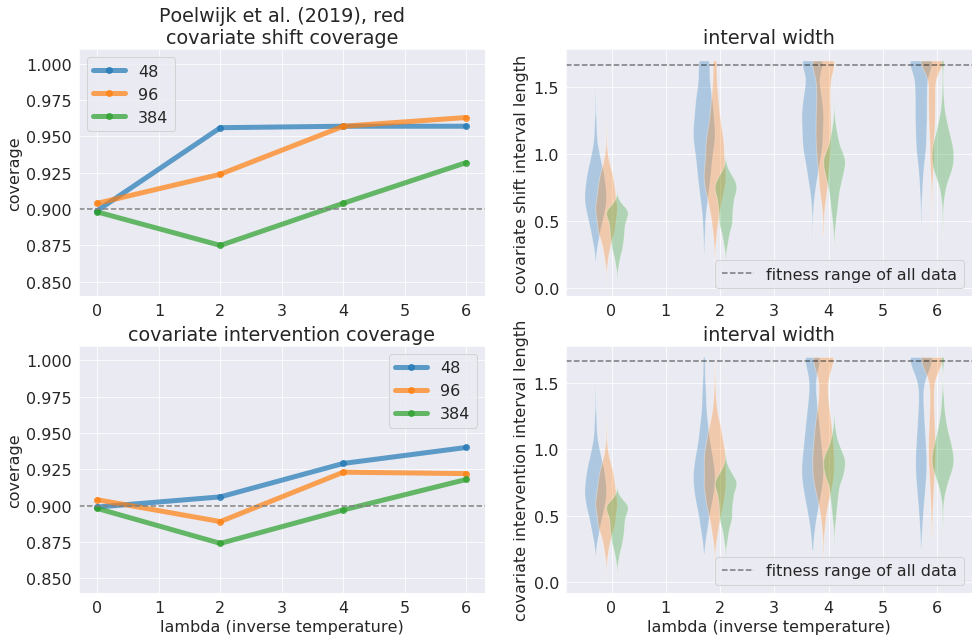

In [3]:
alpha = 0.1
plt.figure(figsize=(16, 10))
offsets = np.arange(-len(n_trains) / 2, len(n_trains) / 2 + 1)
data = assay.PoelwijkData(fitness_str, order=1)
arrl = np.array(lmbdas)

plt.subplot(221)

for cov_l in cscov_txl:
    plt.plot(lmbdas, cov_l, '-o', linewidth=5, alpha=0.7)
plt.axhline(1 - alpha, linestyle="--", color='gray')
plt.ylabel('coverage'); plt.ylim([0.84, 1.01]);
plt.title("Poelwijk et al. (2019), {}\ncovariate shift coverage".format(fitness_str));
plt.legend(n_trains);

plt.subplot(222)

for l, len_lxs in enumerate(cslen_txlxs):
    plt.violinplot(len_lxs.T, arrl + offsets[l] * 0.2, widths=0.4, showextrema=False)
plt.ylabel('covariate shift interval length');
plt.axhline(np.max(data.y_n) - np.min(data.y_n), linestyle='--', color='k', alpha=0.5,
            label='fitness range of all data');
plt.legend(loc='lower right');
plt.title('interval width');

plt.subplot(223)

for cov_l in cicov_txl:
    plt.plot(lmbdas, cov_l, '-o', linewidth=5, alpha=0.7)
plt.axhline(1 - alpha, linestyle="--", color='gray')
plt.xlabel('lambda (inverse temperature)');
plt.ylabel('coverage'); plt.ylim([0.84, 1.01]);
plt.title("covariate intervention coverage".format(fitness_str));
plt.legend(n_trains);

plt.subplot(224)

for l, len_lxs in enumerate(cilen_txlxs):
    plt.violinplot(len_lxs.T, arrl + offsets[l] * 0.2, widths=0.4, showextrema=False)
plt.xlabel('lambda (inverse temperature)');
plt.ylabel('covariate intervention interval length');
plt.axhline(np.max(data.y_n) - np.min(data.y_n), linestyle='--', color='k', alpha=0.5,
            label='fitness range of all data');
plt.legend(loc='lower right');
plt.title('interval width');

## stratified by fitness

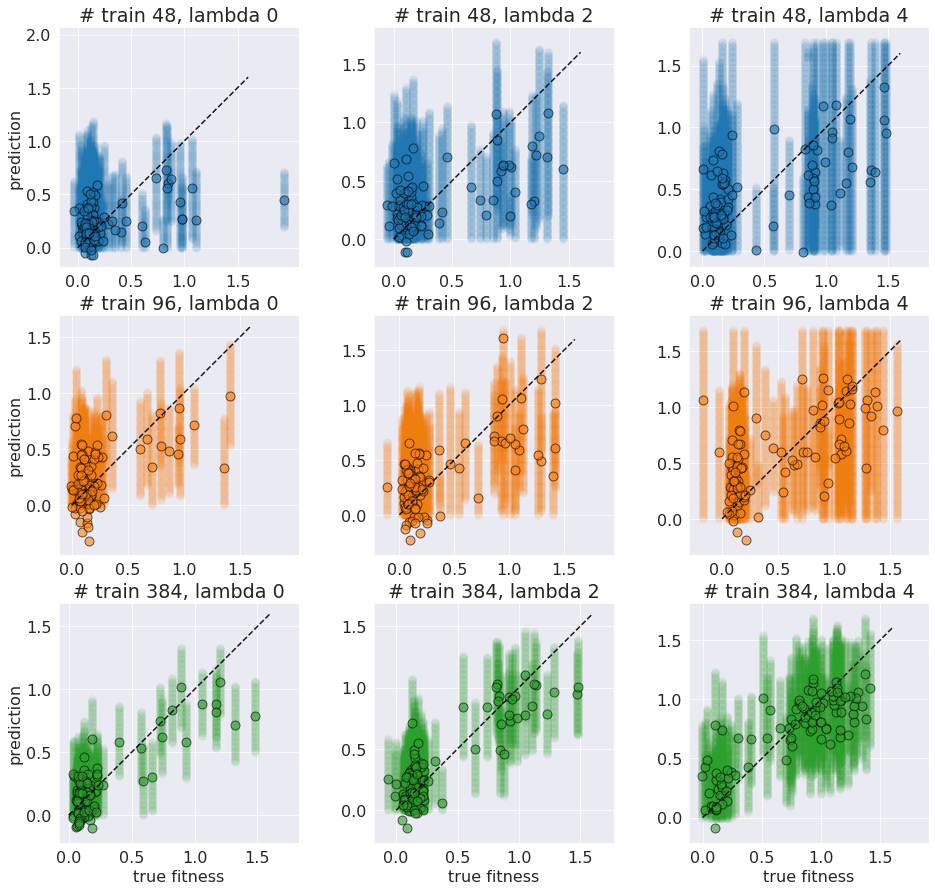

In [5]:
plt.figure(figsize=(16, 15));
n_train_idx = [0, 1, 2]
lmbda_idx = [0, 1, 2]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
seeds = range(100)
alpha = 0.06

for t in n_train_idx:
    for l in lmbda_idx:
        plt.subplot(len(n_train_idx), len(lmbda_idx), t * len(lmbda_idx) + l + 1)
        
        for seed in seeds:
            ciset = sets_txl[t][l][seed]
            plt.scatter(y_txlxs[t, l, seed] * np.ones([ciset.size]), ciset, color=colors[t], alpha=alpha, s=60)

        plt.scatter(y_txlxs[t, l, seeds], pred_txlxs[t, l, seeds], color=colors[t],
                    alpha=0.6, s=80, edgecolors='k');
        
        util.plot_xy([0, 1.6], [0, 1.6], color='k');
        plt.axis('square');
        plt.xticks(np.arange(0, 1.6, 0.5));
        plt.title('# train {}, lambda {}'.format(n_trains[t], lmbdas[l]));
        if t == len(n_trains) - 1:
            plt.xlabel('true fitness');
        if l == 0:
            plt.ylabel('prediction')

## intervention vs. shift lengths

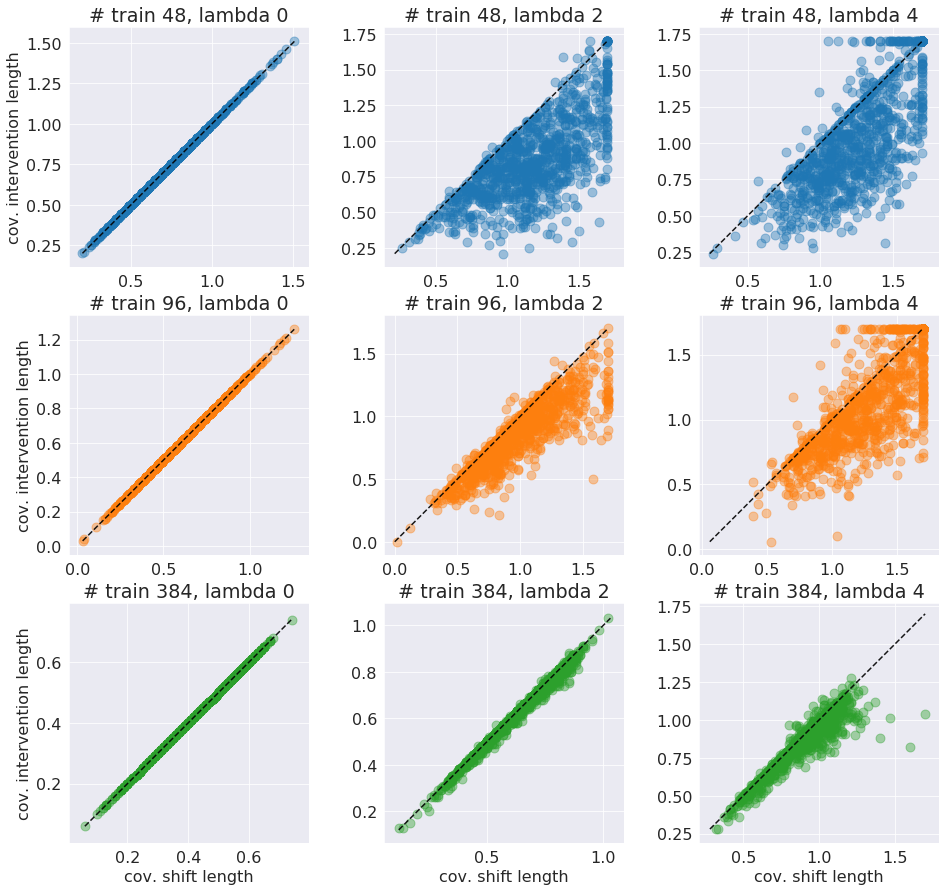

In [5]:
plt.figure(figsize=(16, 15));
# lmbdas = [0, 2, 4, 6]
ntrain_is = [0, 1, 2]
lmbda_js = [0, 1, 2]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha = 0.4

for i, ntrain_i in enumerate(ntrain_is):
    for j, lmbda_j in enumerate(lmbda_js):
        
        plt.subplot(len(ntrain_is), len(lmbda_js), i * (len(lmbda_js)) + j + 1)
        plt.scatter(cslen_txlxs[ntrain_i, lmbda_j], cilen_txlxs[ntrain_i, lmbda_j], color=colors[i],
                    alpha=alpha, s=80);
        
        util.plot_xy(cslen_txlxs[ntrain_i, lmbda_j], cilen_txlxs[ntrain_i, lmbda_j], color='k');
        plt.axis('square');
        # plt.xticks(np.arange(0, 1.6, 0.5));
        plt.title('# train {}, lambda {}'.format(n_trains[ntrain_i], lmbdas[lmbda_j]));
        if i == len(ntrain_is) - 1:
            plt.xlabel('cov. shift length');
        if j == 0:
            plt.ylabel('cov. intervention length')

## plots for interpreting lambda

In [67]:
fitness_str = 'blue'
n_train = 96
reg = 10
order = 2
lmbdas = [0.1, 2, 4, 6, 8]
n_seed = 100
n_samples = 10000

data = assay.PoelwijkData(fitness_str, order=order)
model = Ridge(alpha=reg, fit_intercept=True)

meany_lxs = np.zeros([len(lmbdas), n_seed])
meanpred_lxs = np.zeros([len(lmbdas), n_seed])
maxw_lxs = np.zeros([len(lmbdas), n_seed])
ysamples_lxsxn = np.zeros([len(lmbdas), n_seed, n_samples])

for seed in range(n_seed):
    
    # get random training data
    np.random.seed(seed)
    train_idx = np.random.choice(data.n, n_train, replace=False)
    Xtrain_nxp, ytrain_n = data.X_nxp[train_idx], data.y_n[train_idx]

    # train model
    model.fit(Xtrain_nxp[:, 1 :], ytrain_n)
    
    for l, lmbda in enumerate(lmbdas):
        
        # construct test covariate distribution
        predall_n = model.predict(data.X_nxp[:, 1 :])
        punnorm_n = np.exp(lmbda * predall_n)
        Z = np.sum(punnorm_n)
        p_n = punnorm_n / Z
        
        # draw samples
        idx = np.random.choice(data.n, p=p_n, size=n_samples, replace=True)
        ysamples_lxsxn[l, seed] = data.y_n[idx]
        
        # mean fitness
        meany_lxs[l, seed] = p_n.dot(data.y_n)
        meanpred_lxs[l, seed] = p_n.dot(predall_n)
        
        # max weight
        lr_n = p_n * data.n
        maxw_lxs[l, seed] = np.max(lr_n)

Feature normalization won't work w/ WT-centered distribution!
92 features
Loading estimated SE precomputed with order 7 and significance level 0.01


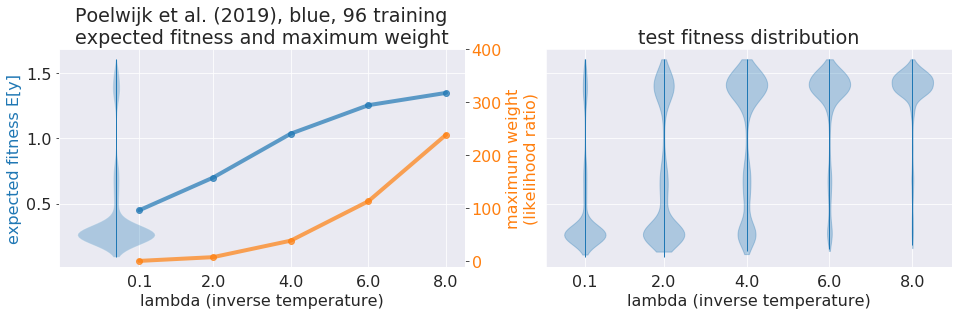

In [70]:
lw = 4
alpha = 0.7
vextremew = 0.3
weight_ylim = [-10, 400]
arrl = np.array(lmbdas)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4));

color = 'tab:blue'
axs[0].set_xlabel('lambda (inverse temperature)');
axs[0].set_ylabel('expected fitness E[y]', color=color);
axs[0].plot(lmbdas, np.mean(meany_lxs, axis=1), '-o', linewidth=lw, color=color, alpha=alpha);
axs[0].set_xticks(lmbdas)
axs[0].violinplot(data.y_n, [-0.5], widths=2, points=100, showextrema=False)
axs[0].vlines(-0.5, np.min(data.y_n), np.max(data.y_n), color=color, linestyle='-', lw=1)
axs[0].set_title('Poelwijk et al. (2019), {}, {} training\nexpected fitness and maximum weight'.format(
    fitness_str, n_train));

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('maximum weight\n(likelihood ratio)', color=color)
ax2.plot(lmbdas, np.mean(maxw_lxs, axis=1), '-o', linewidth=lw, color=color, alpha=alpha);
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(weight_ylim)
ax2.grid(None)

v = axs[1].violinplot(ysamples_lxsxn[:, 2].T, lmbdas, widths=1, points=100, showextrema=False)
for pc in v['bodies']:
    pc.set_color('tab:blue')
    
axs[1].vlines(lmbdas, np.min(ysamples_lxsxn[:, 1].T, axis=0), np.max(ysamples_lxsxn[:, 1].T, axis=0),
              color='tab:blue', linestyle='-', lw=1)
axs[1].get_yaxis().set_ticks([0.5, 1, 1.5]);
axs[1].get_yaxis().set_ticklabels([]);
axs[1].set_xticks(lmbdas)
axs[1].set_xlabel('lambda (inverse temperature)');
axs[1].set_title('test fitness distribution');